In [11]:
import os
print(os.getcwd())

H:\Sub_New_Model\Code_For_Contour_Map


In [10]:
import os

# Change to your project directory (update the path as needed)
os.chdir(r"H:\Sub_New_Model\Code_For_Contour_Map")

# Verify the change
print(os.getcwd())

H:\Sub_New_Model\Code_For_Contour_Map


In [13]:
import os
print(os.getcwd())

H:\Sub_New_Model\Code_For_Contour_Map


In [30]:
import pandas as pd

# Read the Excel file
df = pd.read_excel("groundwater_all_wells_fully_estimated- annual.xlsx")
# Show the first 5 rows
print(df.head())

         lat        lon   1992   1993       1994       1995       1996  \
0  36.098206  59.761354  88.87  88.38  90.037303  90.314052  91.650000   
1  36.110136  59.801812  50.34  50.96  51.913367  52.055166  53.340000   
2  36.149156  59.828758  26.75  26.72  27.360000  27.284804  26.944403   
3  36.160917  59.747949  69.73  71.03  72.000000  71.680000  78.755592   
4  36.173444  59.674010  94.82  91.41  94.558470  94.444000  96.730000   

        1997       1998        1999  ...        2014        2015        2016  \
0  92.720000  94.500000   96.190000  ...  119.530000  121.330000  122.100000   
1  53.248641  55.300000   56.620000  ...   75.410000   77.030000   78.190000   
2  24.250000  24.610000   26.115000  ...   46.800000   47.376461   48.720090   
3  75.961205  74.976216   76.077332  ...  103.320000  106.160000  107.630000   
4  99.430000  98.690000  101.500000  ...  134.205443  136.230084  136.989048   

         2017        2018        2019        2020        2021        2022 

In [31]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from shapely.geometry import Point
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

# Load the Excel file
df = pd.read_excel("groundwater_all_wells_fully_estimated- annual.xlsx")
# Load the shapefile
shapefile_path = "ROI_KH/Aquifer_Clip.shp"
gdf_aquifer = gpd.read_file(shapefile_path)

# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Reproject to match shapefile CRS if needed (e.g., UTM)
if gdf_aquifer.crs != gdf.crs:
    gdf = gdf.to_crs(gdf_aquifer.crs)

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

# Load the Excel file
df = pd.read_excel("groundwater_all_wells_fully_estimated- annual.xlsx")
# Load the shapefile
shapefile_path = "ROI_KH/Aquifer_Clip.shp"
gdf_aquifer = gpd.read_file(shapefile_path)

# --- Shapefile Plot ---
plt.figure(figsize=(8, 6))
gdf_aquifer.plot(color='lightgray', edgecolor='black')
plt.title('Aquifer Shapefile')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# --- Time Series Plot of Annual Means ---
# Define years as numeric values to match DataFrame columns
years = list(range(1992, 2024))
# Check if year columns exist in DataFrame
available_years = [year for year in years if year in df.columns]
if not available_years:
    raise KeyError("No year columns found in DataFrame")

# Calculate mean groundwater level for each year
mean_levels = df[available_years].mean()

# Create time series plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=[str(year) for year in available_years], y=mean_levels, marker='o')
plt.title('Mean Groundwater Level (1992-2023)')
plt.xlabel('Year')
plt.ylabel('Mean Groundwater Level')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show plots
plt.show()

DriverError: ROI_KH/Aquifer_Clip.shp: No such file or directory

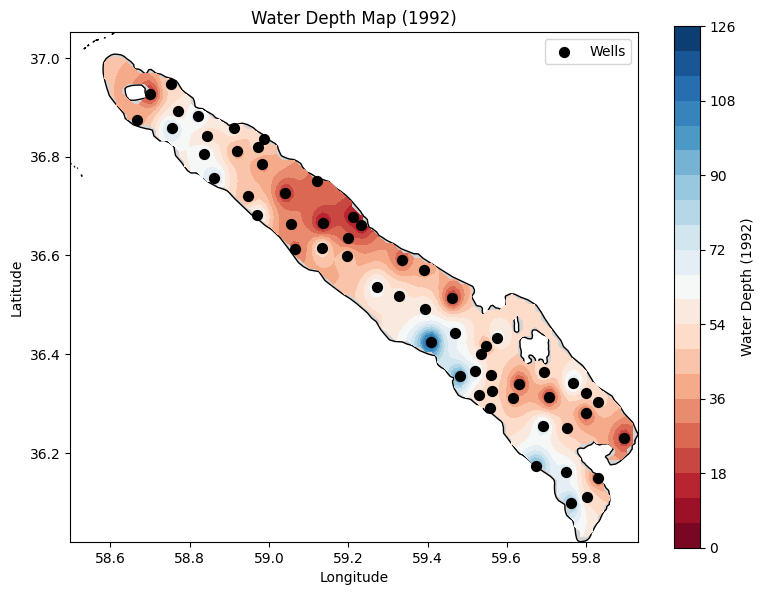

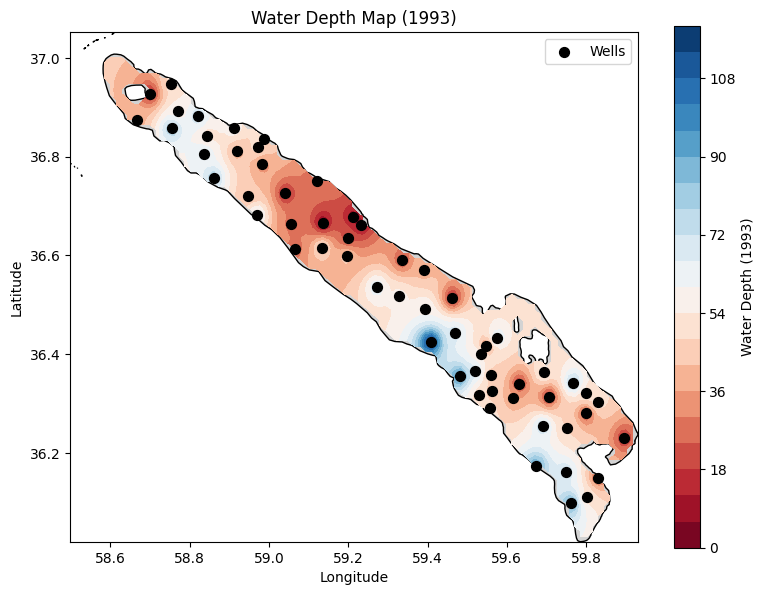

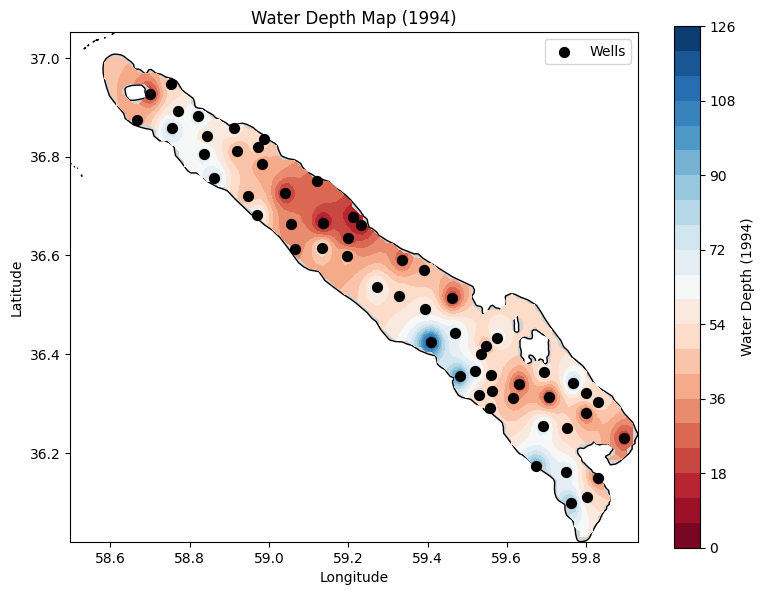

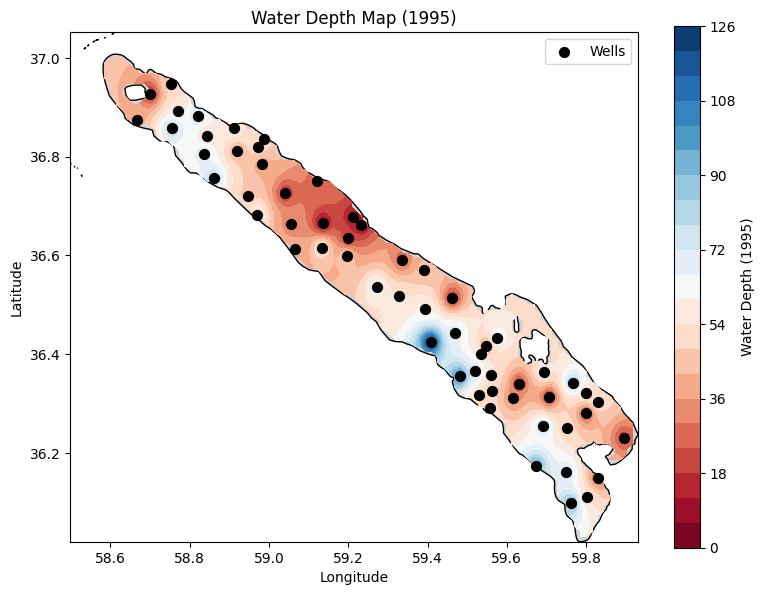

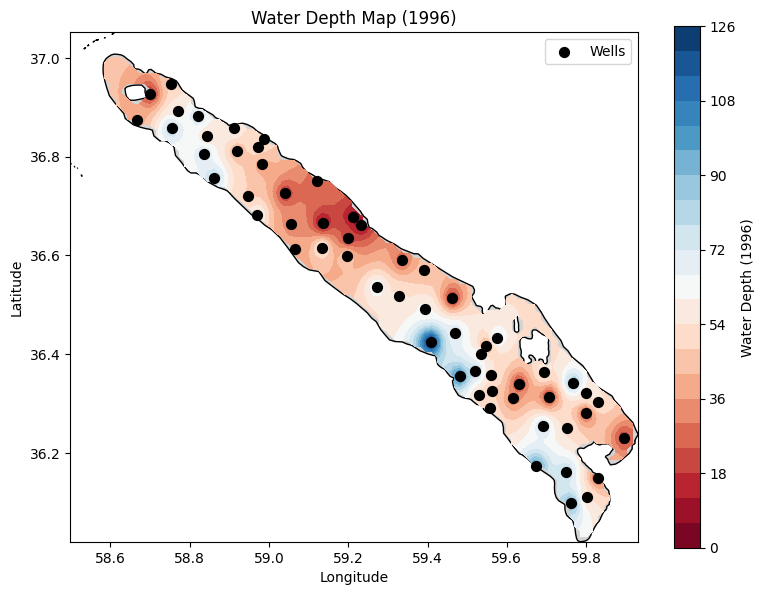

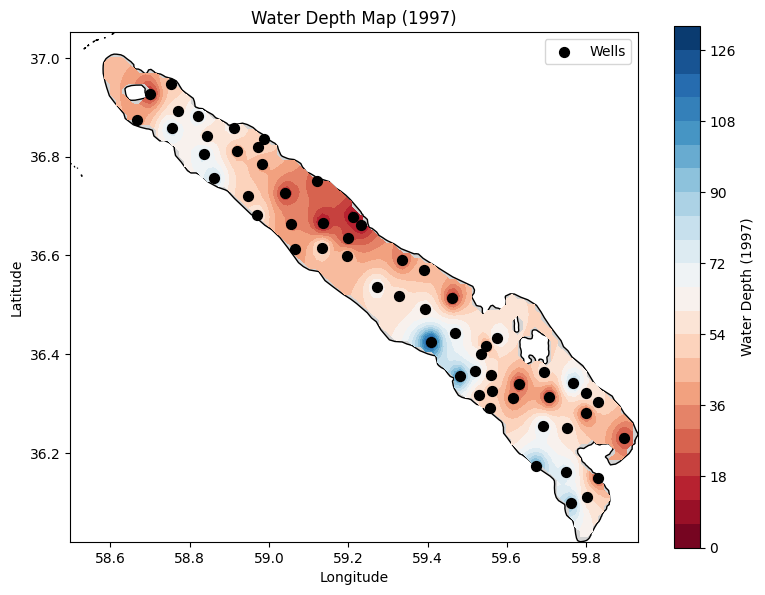

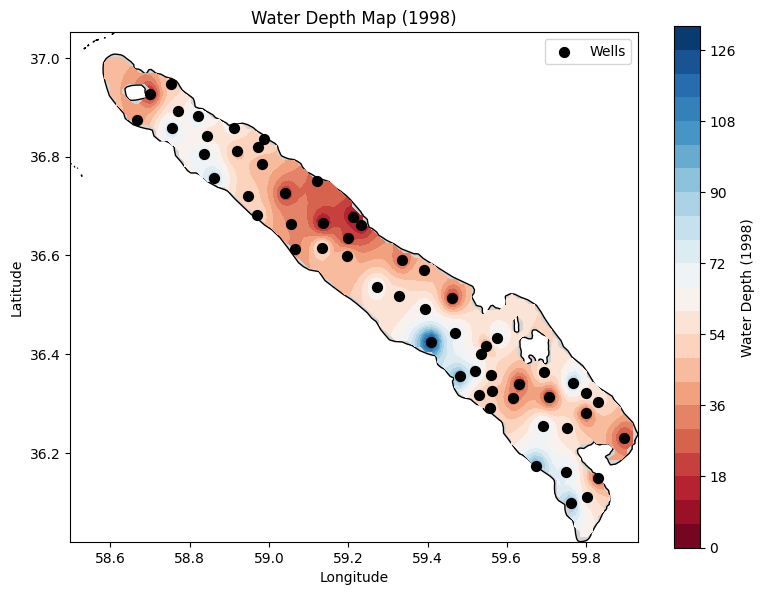

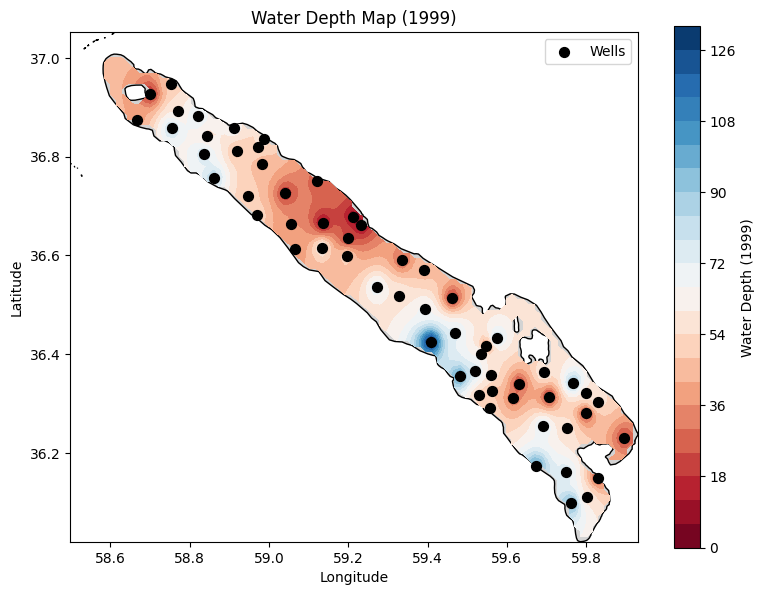

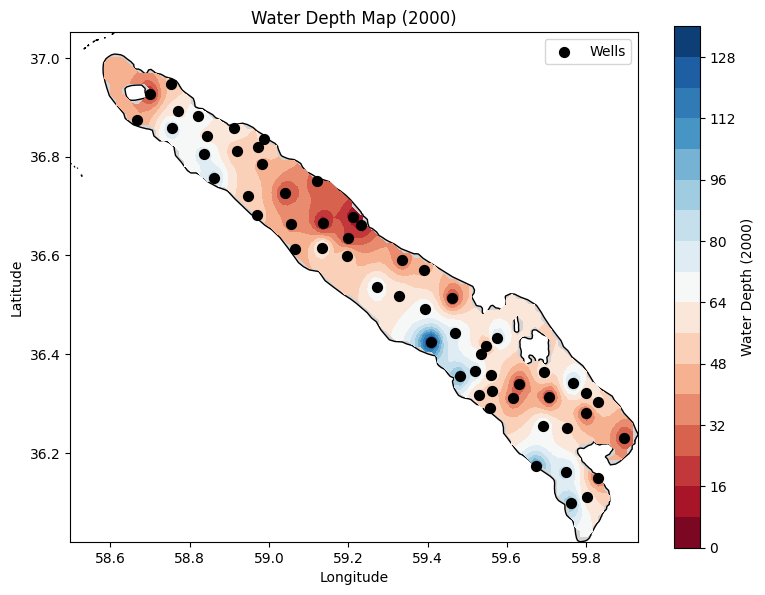

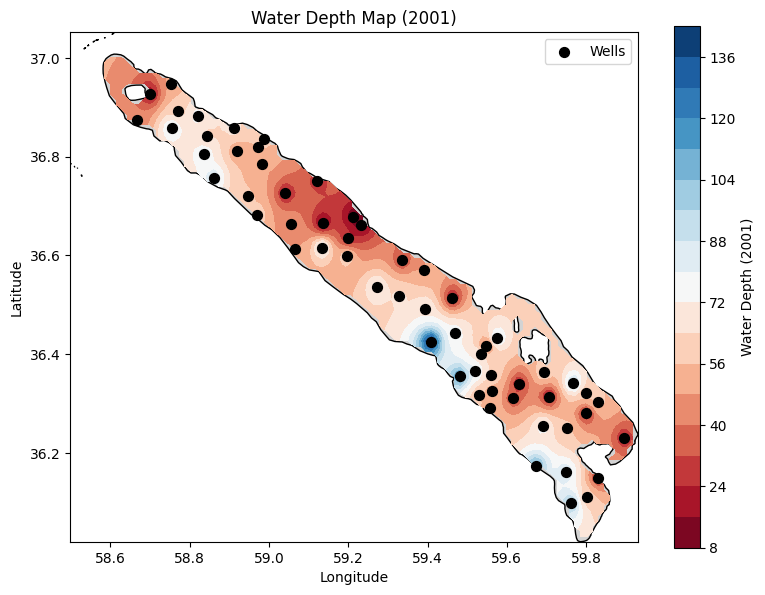

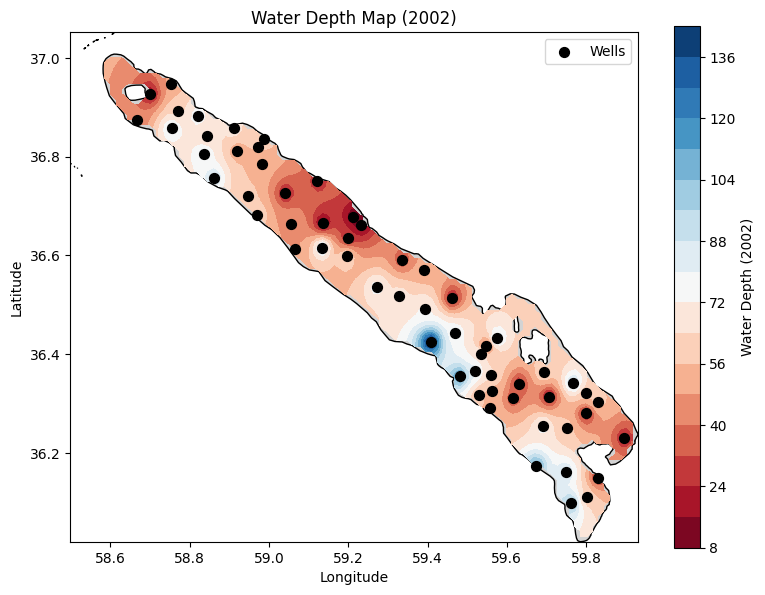

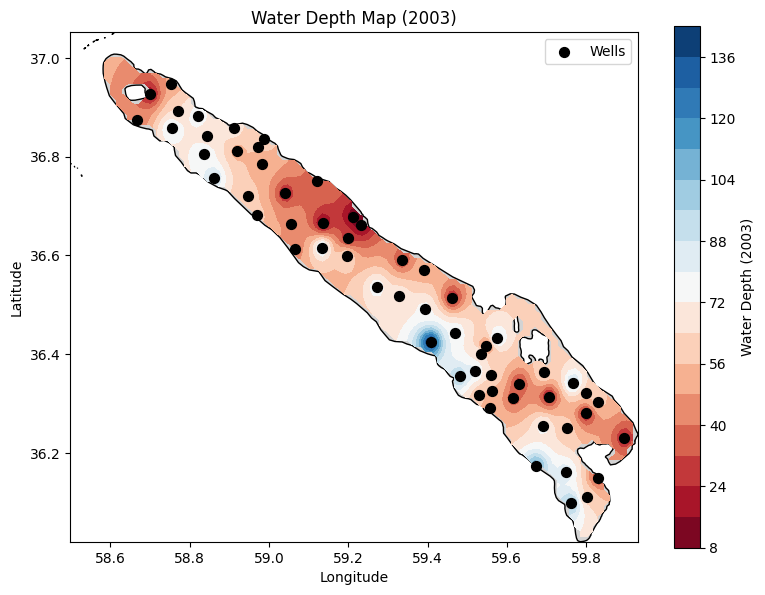

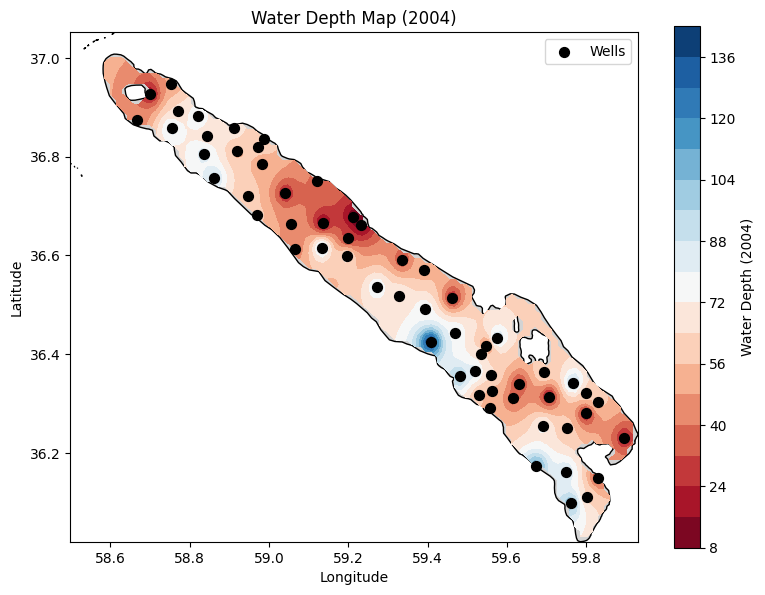

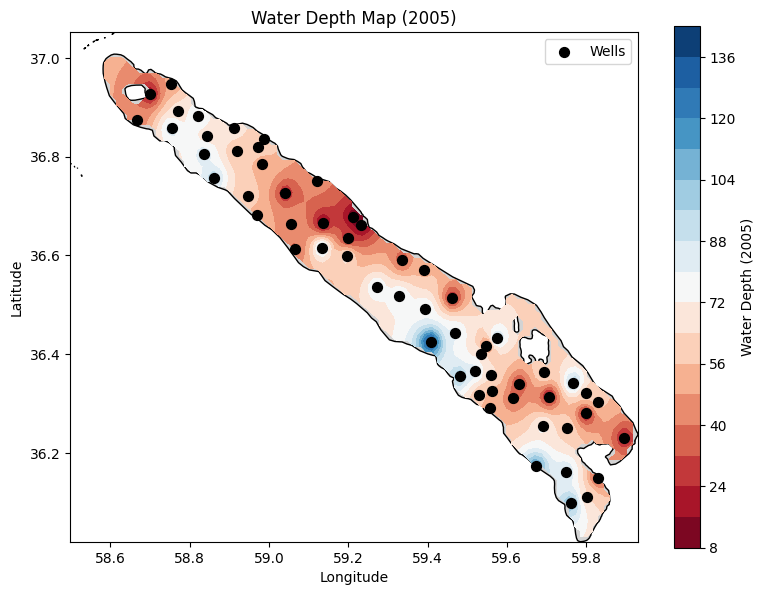

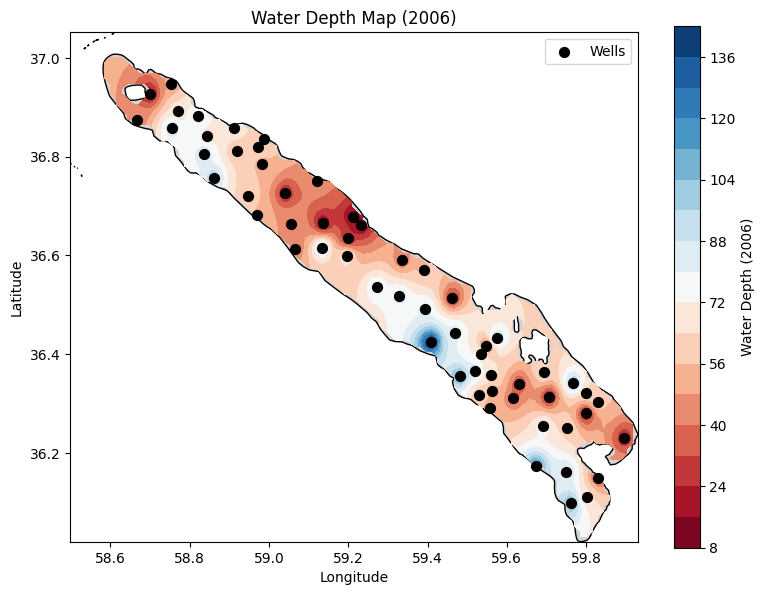

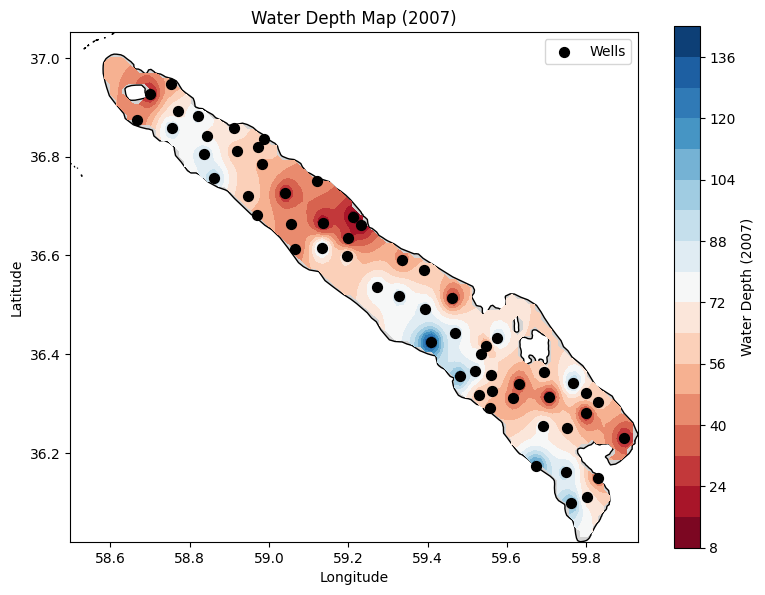

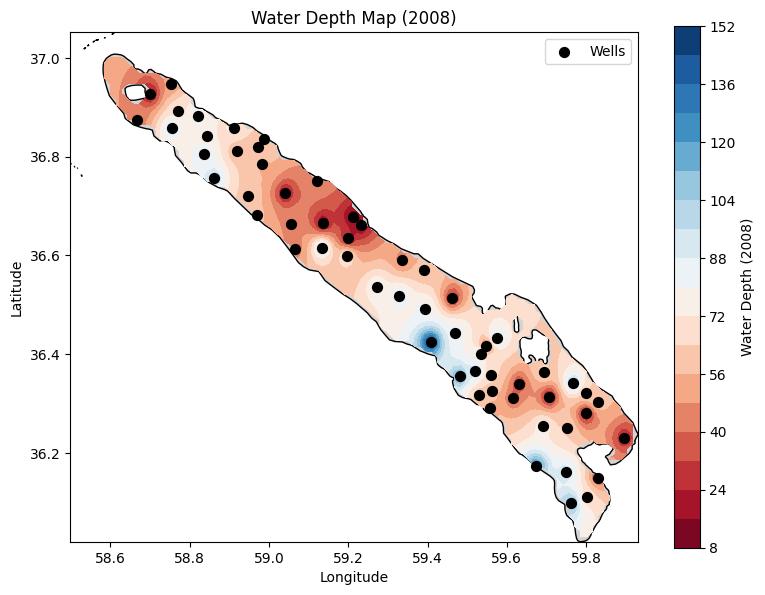

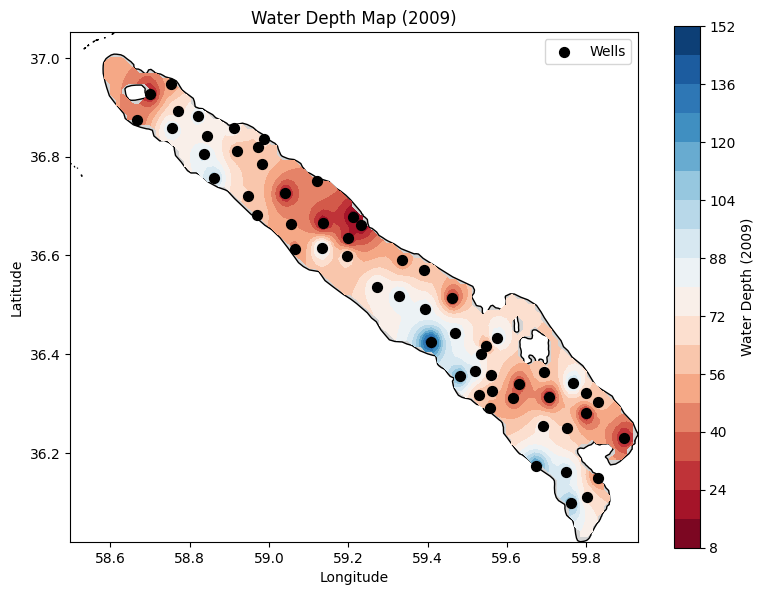

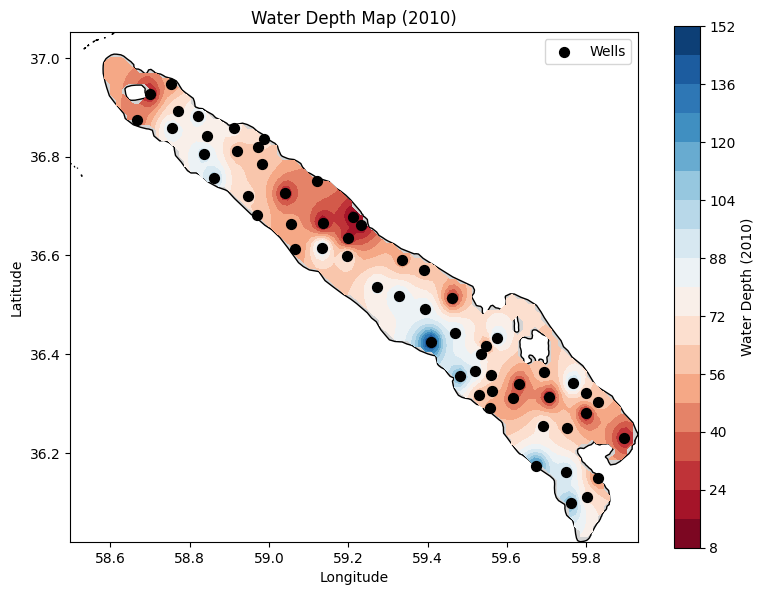

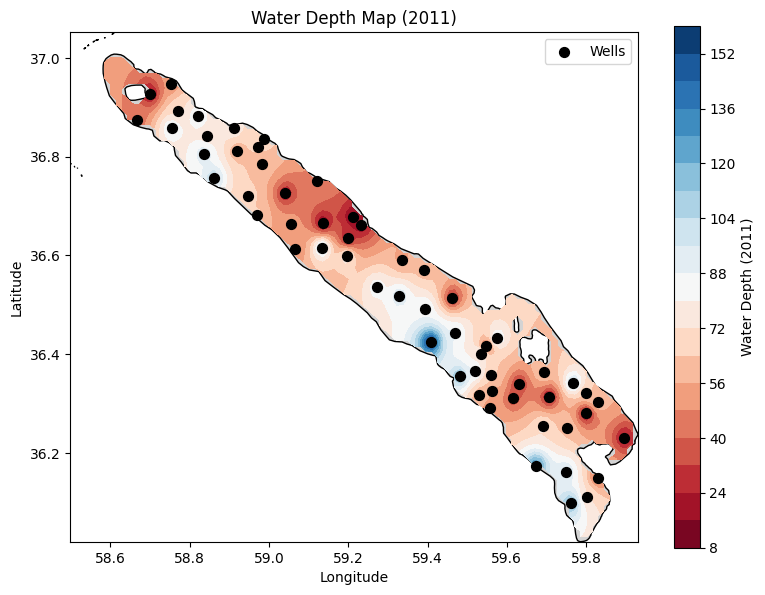

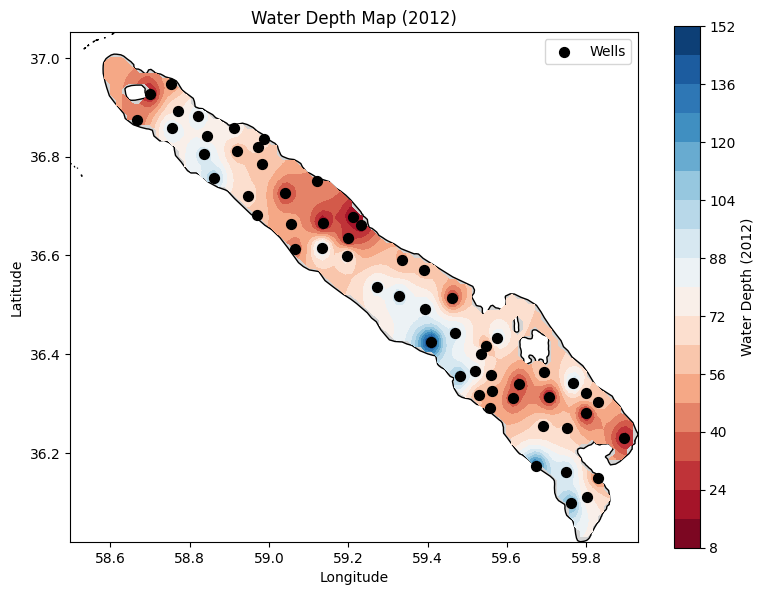

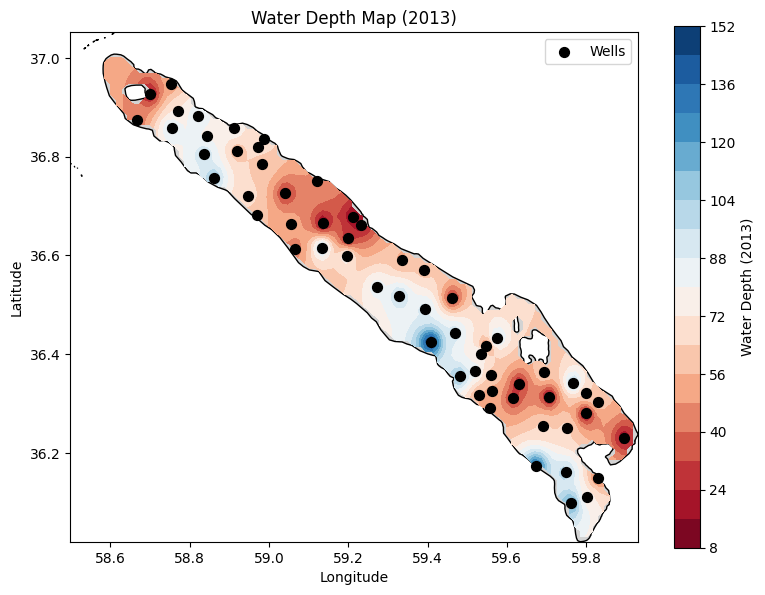

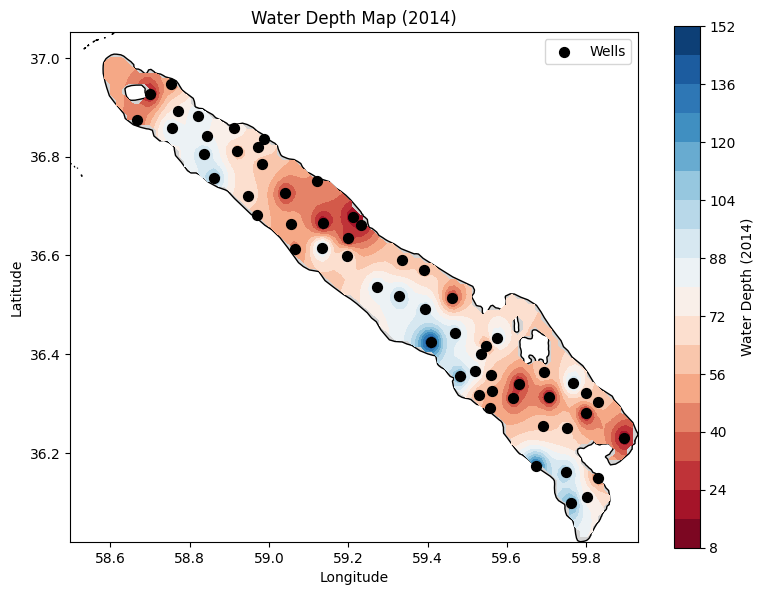

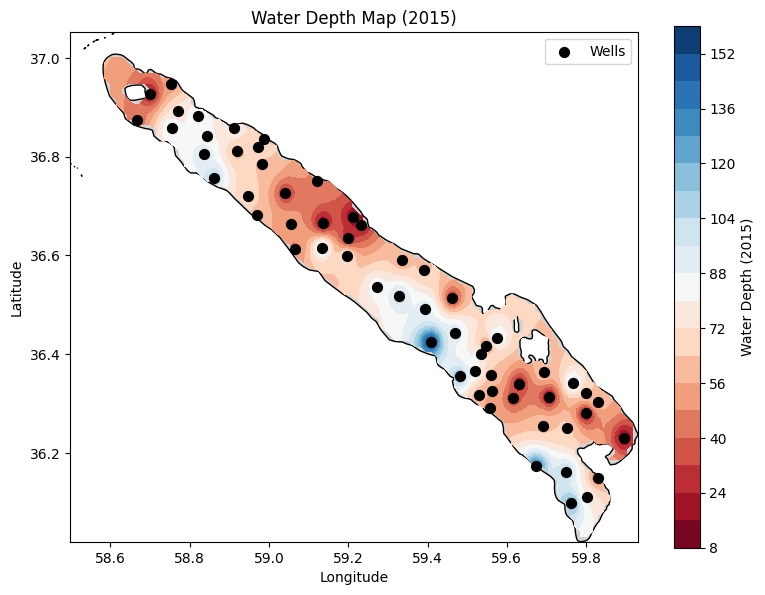

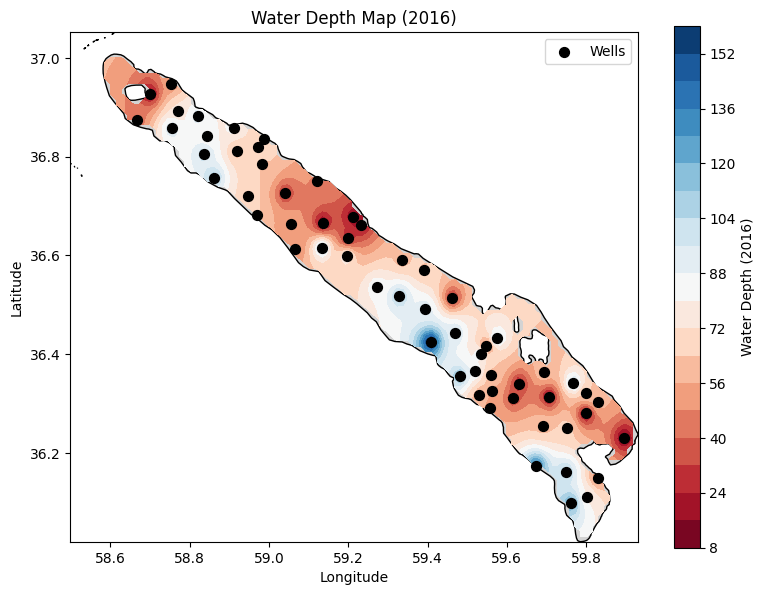

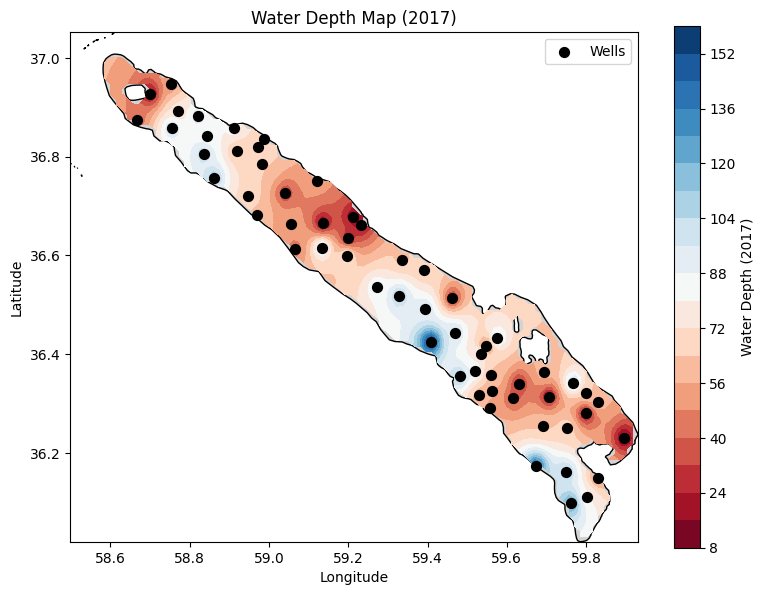

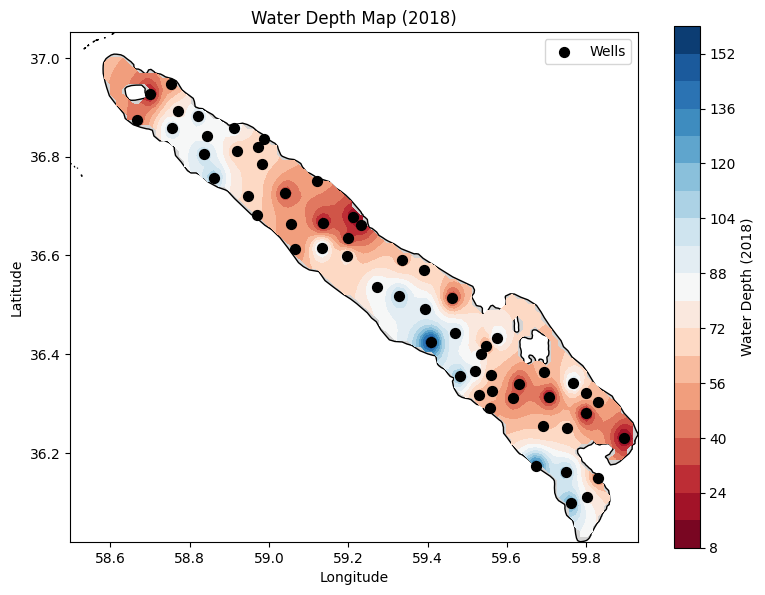

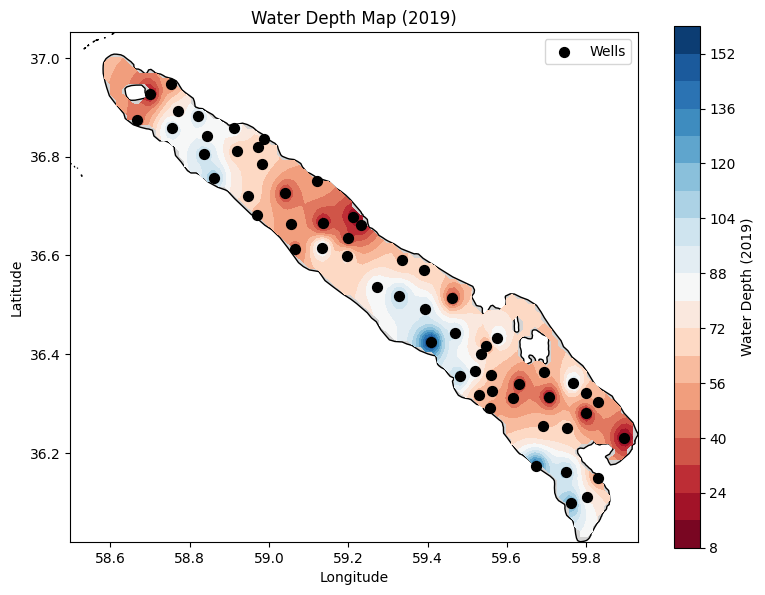

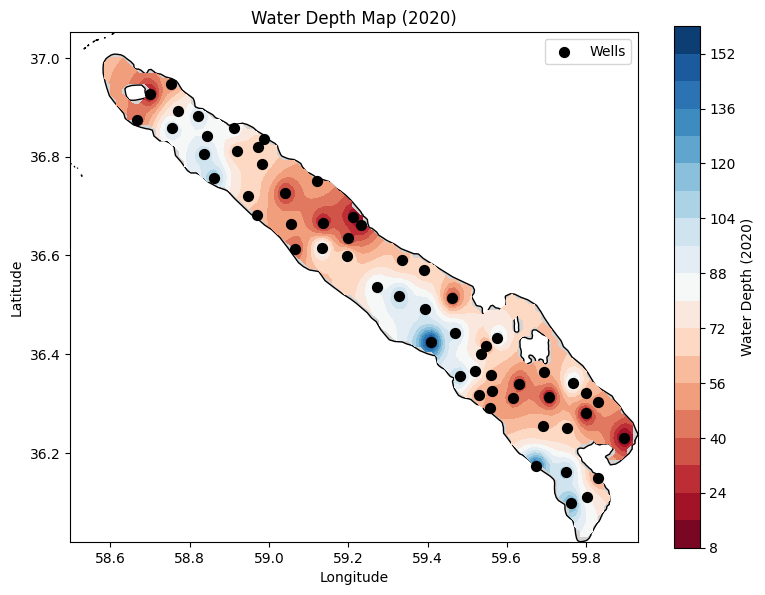

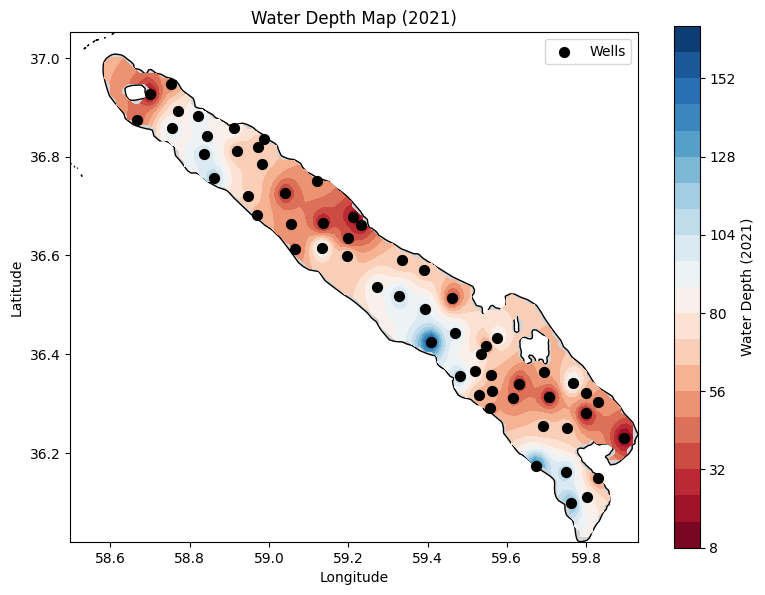

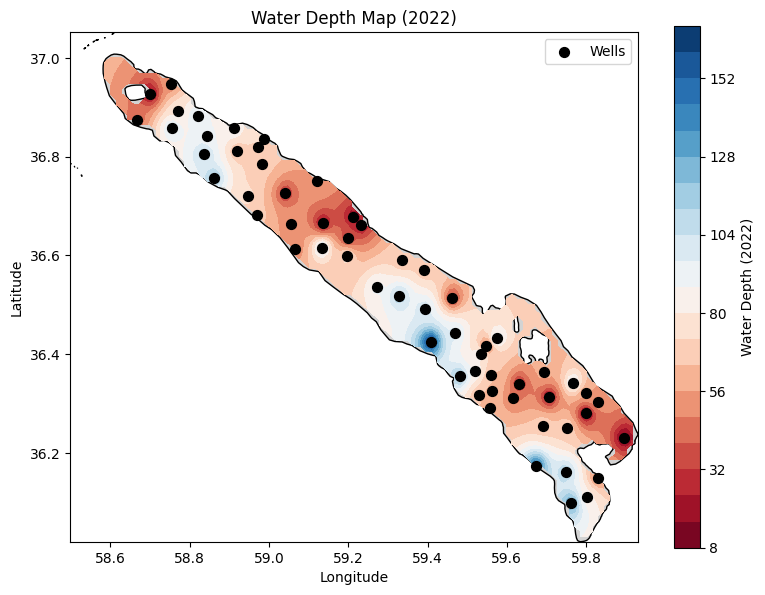

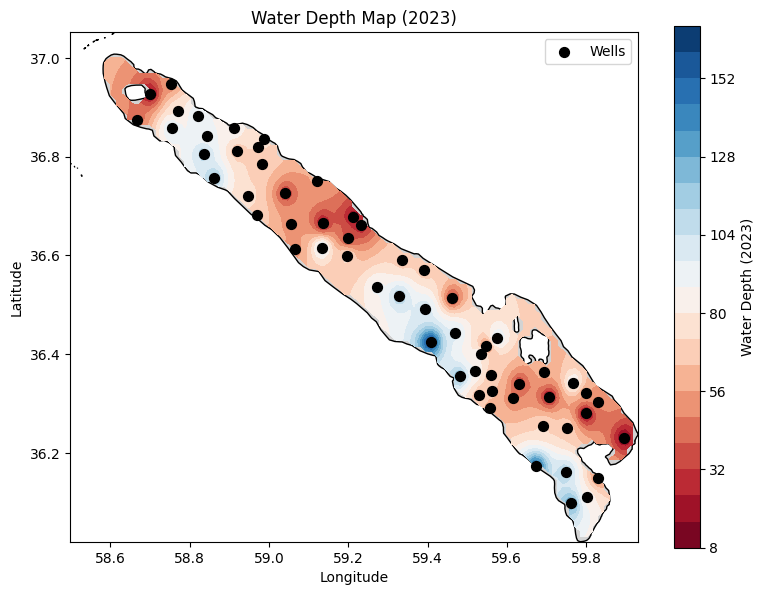

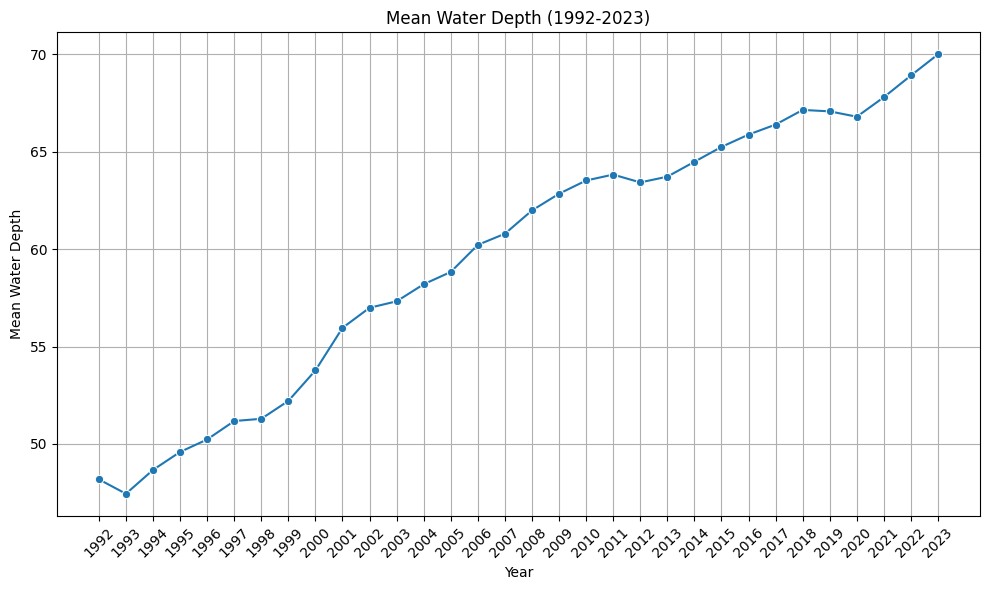

In [38]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from matplotlib.path import Path

# Custom IDW interpolation function
def idw_interpolation(x, y, z, grid_x, grid_y, power=2):
    grid_z = np.zeros_like(grid_x, dtype=float)
    for i in range(grid_x.shape[0]):
        for j in range(grid_x.shape[1]):
            distances = np.sqrt((x - grid_x[i, j])**2 + (y - grid_y[i, j])**2)
            # Avoid division by zero
            distances = np.where(distances == 0, 1e-10, distances)
            weights = 1 / distances**power
            grid_z[i, j] = np.sum(z * weights) / np.sum(weights)
    return grid_z

# Load the Excel file
df = pd.read_excel("groundwater_all_wells_fully_estimated- annual.xlsx")
# Load the shapefile
shapefile_path = "ROI_KH/Aquifer_Clip.shp"
gdf_aquifer = gpd.read_file(shapefile_path)

# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Reproject to match shapefile CRS if needed
if gdf_aquifer.crs != gdf.crs:
    gdf = gdf.to_crs(gdf_aquifer.crs)

# Extract coordinates for interpolation
x = gdf['lon'].values
y = gdf['lat'].values

# Define grid for interpolation based on shapefile bounds
x_min, x_max = gdf_aquifer.bounds['minx'].min(), gdf_aquifer.bounds['maxx'].max()
y_min, y_max = gdf_aquifer.bounds['miny'].min(), gdf_aquifer.bounds['maxy'].max()
grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]

# Create a mask for the shapefile
# Combine all geometries in the shapefile into a single polygon (if multiple polygons exist)
union_geometry = gdf_aquifer.geometry.unary_union
# Create a grid of points to check against the shapefile
grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
mask = np.array([union_geometry.contains(Point(p)) for p in grid_points]).reshape(grid_x.shape)

# --- Map Plots with IDW Interpolation (Masked) for Each Year ---
years = list(range(1992, 2024))
for year in years:
    if year not in df.columns:
        print(f"Skipping year {year}: column not found in DataFrame")
        continue
    
    # Extract water depth for the year
    z = gdf[year].values
    
    # Perform IDW interpolation
    grid_z = idw_interpolation(x, y, z, grid_x, grid_y, power=2)
    
    # Apply mask: set values outside shapefile to NaN
    grid_z_masked = np.where(mask, grid_z, np.nan)
    
    # Create figure for map
    plt.figure(figsize=(8, 6))
    # Plot aquifer shapefile
    gdf_aquifer.plot(ax=plt.gca(), color='lightgray', edgecolor='black')
    # Plot masked interpolated water depth
    contour = plt.contourf(grid_x, grid_y, grid_z_masked, levels=20, cmap='RdBu')
    plt.colorbar(contour, label=f'Water Depth ({year})')
    # Plot well locations
    gdf.plot(ax=plt.gca(), color='black', markersize=50, label='Wells')
    plt.title(f'Water Depth Map ({year})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Time Series Plot of Annual Means ---
# Calculate mean water depth for each year
available_years = [year for year in years if year in df.columns]
mean_levels = df[available_years].mean()

# Create time series plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=[str(year) for year in available_years], y=mean_levels, marker='o')
plt.title('Mean Water Depth (1992-2023)')
plt.xlabel('Year')
plt.ylabel('Mean Water Depth')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show time series plot
plt.show()

In [21]:
for year in years:
    plt.figure(figsize=(8, 6))
    sns.histplot(gdf[year], bins=20, kde=True)
    plt.title(f'Groundwater Depth Distribution - {year}')
    plt.xlabel('Depth (m)')
    plt.ylabel('Frequency')
    plt.savefig(f'histogram_{year}.png')
    plt.close()

In [23]:
plt.figure(figsize=(12, 6))
gdf[years].boxplot()
plt.title('Groundwater Depth by Year')
plt.xlabel('Year')
plt.ylabel('Depth (m)')
plt.xticks(rotation=45)
plt.savefig('boxplot_all_years.png')
plt.close()